In [1]:
# import nasdaqdatalink as ndl
# ndl.ApiConfig.api_key = "jsxy8zENXnPx9xpYeqKk"
# NASDAQ_DATA_LINK_API_KEY
import yfinance as yf
sp500_data = yf.download('^GSPC', start='1957-03-04', end='2020-12-31')['Close']

[*********************100%%**********************]  1 of 1 completed


#### Hypothesis
The U.S. has implemented quantitative easing in November 2008 in response to the global financial crisis.

**Null Hypothesis**:
The S&P 500 average monthly return is not different before and after 2008. $H_0: \mu_1 = \mu_2$

**Alternative Hypothesis**:
The S&P 500 average monthly return is different before and after 2008. $H_1: \mu_1 \neq \mu_2$

<Axes: title={'center': 'S&P 500 Historical Prices'}, xlabel='Date', ylabel='Close Price'>

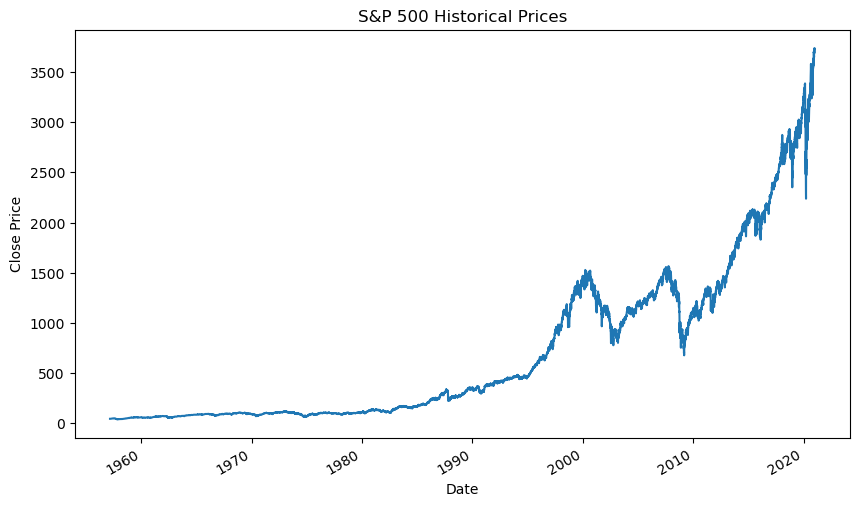

In [2]:
sp500_data.plot(figsize=(10, 6), title="S&P 500 Historical Prices", ylabel="Close Price")

#### Identifying the Test Statistic & Probability Distribution

Student test statistic with pooled variance. Assuming that returns are approximately normal and population variances are equal.

In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

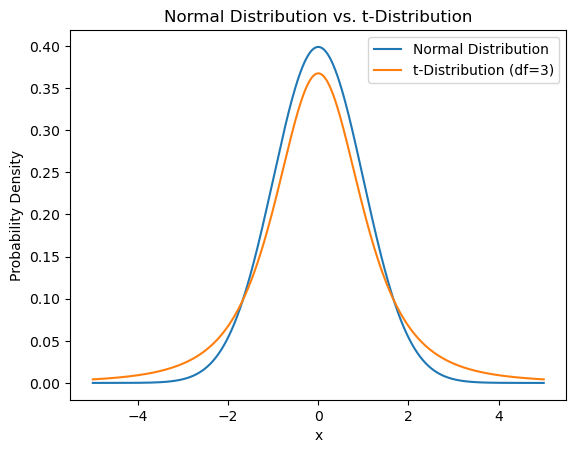

In [4]:
xs = np.linspace(-5,5,1000)
plt.plot(xs, stats.norm.pdf(xs), label='Normal Distribution')
degree_of_freedom = 3
plt.plot(xs, stats.t.pdf(xs, degree_of_freedom), label=f't-Distribution (df={degree_of_freedom})')
plt.legend()
plt.title('Normal Distribution vs. t-Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

#### Rejection Rule

If test statistic is larger than the value ↓.

In [5]:
# Set the significance level
alpha = 0.05
critical_value = stats.t.isf(alpha/2, 4524) # two sided test with df = 4524
critical_value

1.9604884971947123

#### Test statistic calculation

In [6]:
returns = sp500_data.pct_change()
returns.name = 'Returns'

In [7]:
before_gfc_ts = returns.loc['2000-01-01':'2008-12-31']
after_gfc_ts = returns.loc['2009-01-01':'2017-12-27']
n1 = before_gfc_ts.count()
n2 = after_gfc_ts.count()
n1 == n2

True

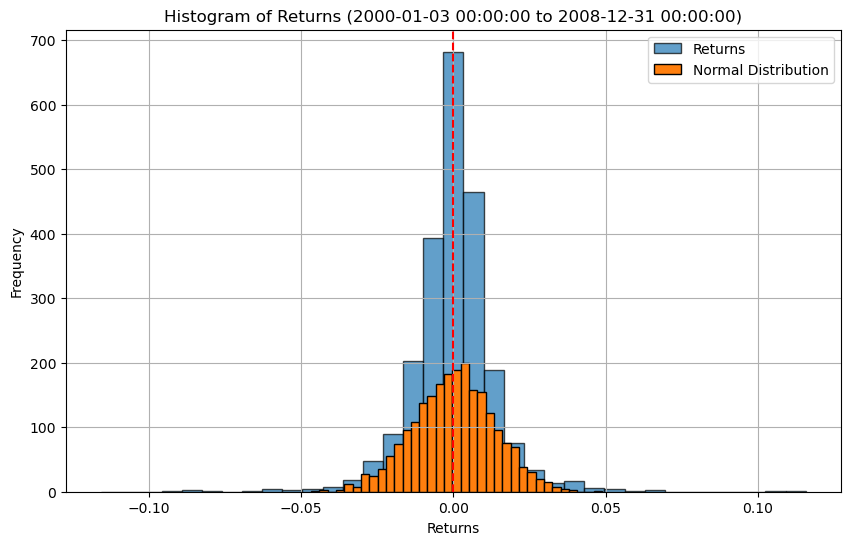

In [8]:
plt.figure(figsize=(10, 6))
before_gfc_ts.plot.hist(bins=35, edgecolor='black', alpha=0.7, range=(-before_gfc_ts.apply(abs).max(), before_gfc_ts.apply(abs).max()))
plt.hist(stats.norm.rvs(before_gfc_ts.mean(), before_gfc_ts.std(), n1),bins=35,edgecolor='black',label="Normal Distribution")
plt.title(f'Histogram of Returns ({before_gfc_ts.index.min()} to {before_gfc_ts.index.max()})')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.axvline(x=before_gfc_ts.mean(), color='r', linestyle='--')  # Add a vertical line at 0
plt.legend()
plt.grid(True)
plt.show()

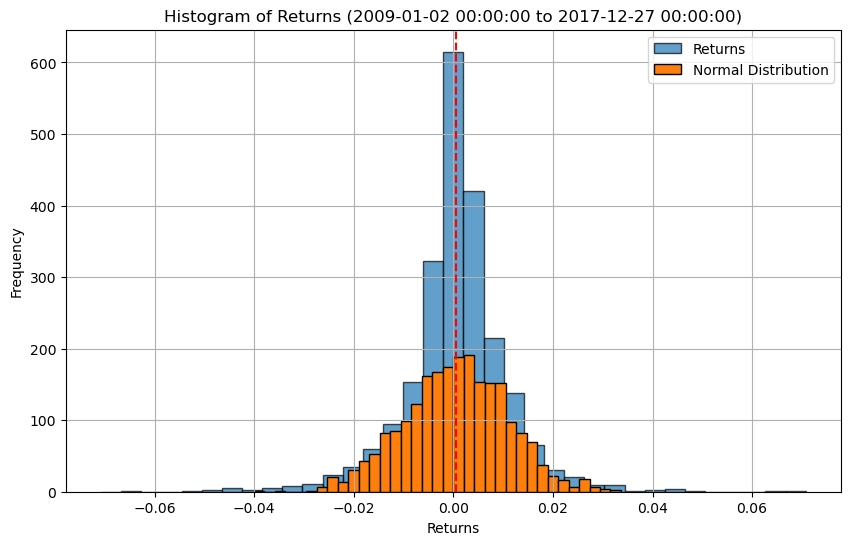

In [9]:
plt.figure(figsize=(10, 6))
after_gfc_ts.plot.hist(bins=35, edgecolor='black', alpha=0.7, range=(-after_gfc_ts.apply(abs).max(), after_gfc_ts.apply(abs).max()))
plt.hist(stats.norm.rvs(after_gfc_ts.mean(), after_gfc_ts.std(), n1),bins=35,edgecolor='black',label="Normal Distribution")
plt.title(f'Histogram of Returns ({after_gfc_ts.index.min()} to {after_gfc_ts.index.max()})')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.axvline(x=after_gfc_ts.mean(), color='r', linestyle='--')  # Add a vertical line at 0
plt.legend()
plt.grid(True)
plt.show()

It seems there is a difference!

### Assumption of equal population variance

In [10]:
x1 = before_gfc_ts.mean()
x2 = after_gfc_ts.mean()

s1 = before_gfc_ts.var()
s2 = after_gfc_ts.var()

df = n1 + n2 -2

pooled_var = ((n1-1)*s1 + (n2-1)*s2)/df

# Calculate the t-statistic
test_statistic = np.array(((x1 - x2) - 0) / np.sqrt((pooled_var/n1) + (pooled_var/n2))) # mu1 - mu2 = 0

# another easier method
t_stat, p_value = stats.ttest_ind(before_gfc_ts, after_gfc_ts, equal_var=True, nan_policy='omit')

round(test_statistic.item(),7) == round(t_stat,7) 

True

#### Make a decision

In [11]:
# Check if the null hypothesis should be rejected
if np.abs(test_statistic) > critical_value:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Fail to reject the null hypothesis.


In [12]:
# Another method
if p_value < alpha:
    print("Reject the null hypothesis. The two time series have significantly different means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude that the two time series have different means.")

Fail to reject the null hypothesis. There is not enough evidence to conclude that the two time series have different means.


### Assumption of unequal population variances tested using F distribution

In [13]:
df1 = n1-1
df2 = n2-1
F_test_statistic = (s1 / s2)**2 # higher over lower std of the two series
F_test_statistic

2.8617372626125936

In [14]:
from scipy.stats import f
lower_crit_value = f.ppf(alpha/2, df1, df2)
upper_crit_value = f.ppf(1 - alpha/2, df1, df2)
print(f"Lower and Upper critical values at {alpha/2} and {1 - alpha/2}:", lower_crit_value, upper_crit_value )

Lower and Upper critical values at 0.025 and 0.975: 0.9208661167181751 1.0859341893953551


In [15]:
if F_test_statistic > upper_crit_value or F_test_statistic < lower_crit_value:
    print("Reject the null hypothesis. The two time series have significantly different variances.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude that the two time series have different variances.")

Reject the null hypothesis. The two time series have significantly different variances.


#### Welch's unequal variances t-test

In [16]:
test_statistic = ((x1 - x2) - 0)/((s1**2/n1) + (s2**2/n2))**0.5
df = ((s1**2/n1) + (s2**2/n2))**2/(((s1**2 / n1)**2 /n1)+((s2**2 / n2)**2/n2))
t_stat, p_value = stats.ttest_ind(before_gfc_ts, after_gfc_ts, equal_var=True, nan_policy='omit')
if p_value < alpha:
    print("Reject the null hypothesis. The two time series have significantly different means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude that the two time series have different means.")

Fail to reject the null hypothesis. There is not enough evidence to conclude that the two time series have different means.


##  Check Normality of Returns Assumption

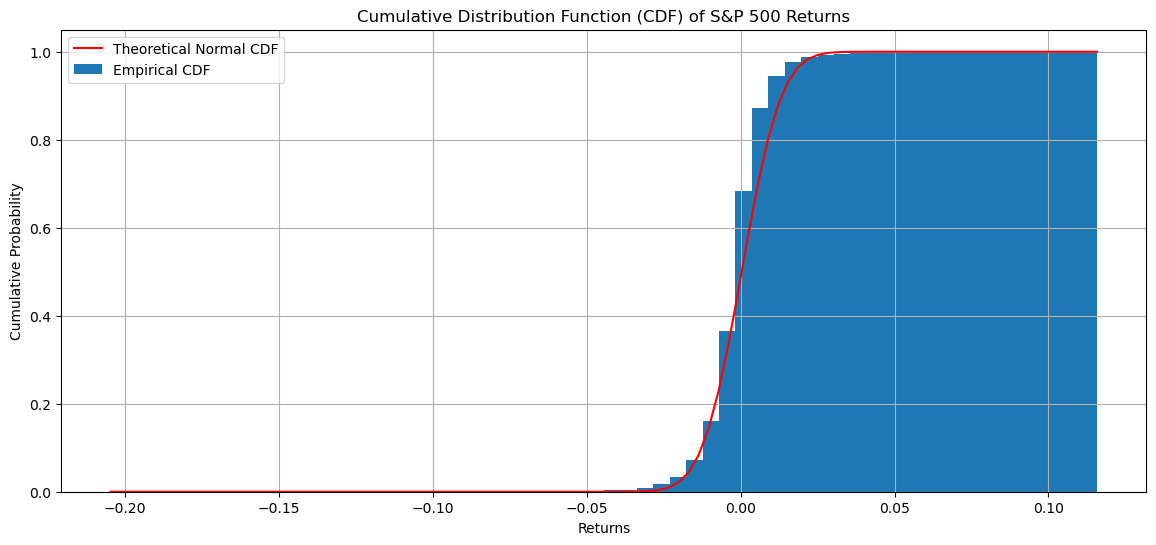

In [17]:
# Plot the theoretical normal CDF
mean = returns.mean()
std = returns.std()
x = np.linspace(returns.min(), returns.max(), 100)
plt.figure(figsize=(14, 6))
plt.plot(x, stats.norm.cdf(x, loc=mean, scale=std), color='r', label='Theoretical Normal CDF')
# Plot the empirical CDF with normalized histogram frequency
plt.hist(returns, bins=60, cumulative=True, density=True, label='Empirical CDF')
plt.title('Cumulative Distribution Function (CDF) of S&P 500 Returns')
plt.xlabel('Returns')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

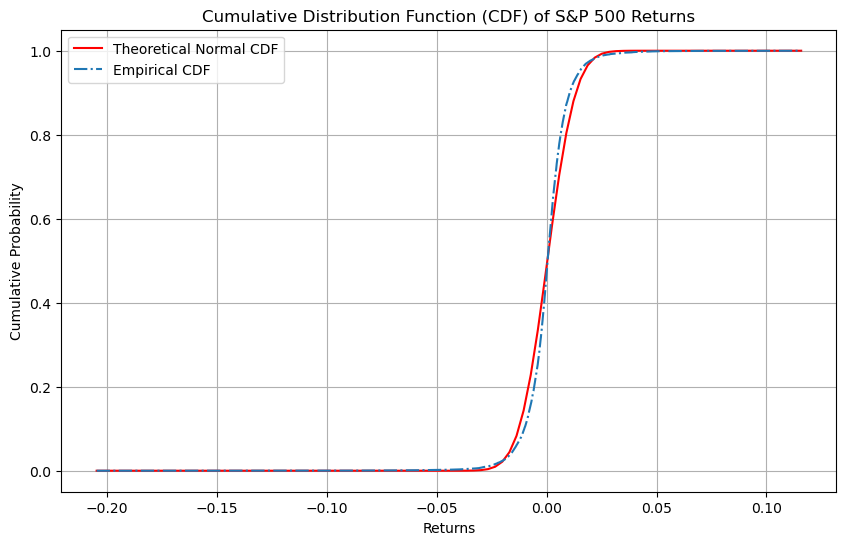

In [18]:
# Calculate the empirical CDF
sorted_returns = returns.sort_values()
cdf = (sorted_returns.rank() - 1) / (len(returns) - 1)

# Plot the theoretical normal CDF
plt.figure(figsize=(10, 6))
plt.plot(x, stats.norm.cdf(x, loc=mean, scale=std), color='r', label='Theoretical Normal CDF')
# Plot the empirical CDF
plt.plot(sorted_returns, cdf, linestyle='-.', label='Empirical CDF')
# plt.step(sorted_returns, cdf, where='post', label='Empirical CDF')
plt.title('Cumulative Distribution Function (CDF) of S&P 500 Returns')
plt.xlabel('Returns')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

### Kolmogorov-Smirnov test

The Kolmogorov-Smirnov test is a non-parametric test that compares the empirical distribution function of two samples to determine if they come from the same continuous distribution. The alternative hypothesis is that they have different distributions.

In [19]:
ks_result = stats.ks_2samp(before_gfc_ts, after_gfc_ts)

# Print the test results
print("\nKolmogorov-Smirnov test:")
print(f"Test statistic: {ks_result.statistic:.4f}")
print(f"P-value: {ks_result.pvalue:.4f}")

# Determine if the null hypotheses are rejected
if ks_result.pvalue < alpha:
    print("\nNull hypothesis rejected: The before and after returns do not have the same distribution.")
else:
    print("\nNull hypothesis not rejected: The before and after returns have the same distribution.")


Kolmogorov-Smirnov test:
Test statistic: 0.0919
P-value: 0.0000

Null hypothesis rejected: The before and after returns do not have the same distribution.


### Lilliefors test

The Lilliefors test is a normality test that is a modified version of the Kolmogorov-Smirnov test.
It is specifically designed to test the null hypothesis that the data comes from a normally distributed population, without requiring the estimation of any parameters (mean and standard deviation) from the data.

In [20]:
from statsmodels.stats.diagnostic import lilliefors
lilliefors_result_before = lilliefors(before_gfc_ts)
lilliefors_result_after = lilliefors(after_gfc_ts)

split_date = '2008-12-31'
# Print the test results
print("\nLilliefors test:")
print(f"Time Series 1 (before {split_date}):")
print(f"Test statistic: {lilliefors_result_before[0]:.4f}")
print(f"P-value: {lilliefors_result_before[1]:.4f}")
print(f"Time Series 2 (on or after {split_date}):")
print(f"Test statistic: {lilliefors_result_after[0]:.4f}")
print(f"P-value: {lilliefors_result_after[1]:.4f}")

# Determine if the null hypotheses are rejected
if lilliefors_result_before[1] < alpha or lilliefors_result_after[1] < alpha:
    print("\nNull hypothesis rejected: The returns are not normally distributed.")
else:
    print("\nNull hypothesis not rejected: The returns are normally distributed.")


Lilliefors test:
Time Series 1 (before 2008-12-31):
Test statistic: 0.0846
P-value: 0.0010
Time Series 2 (on or after 2008-12-31):
Test statistic: 0.1027
P-value: 0.0010

Null hypothesis rejected: The returns are not normally distributed.


### Jarque Bera test

A symmetric distribution, such as the normal distribution, is characterized by the parts on either side of the mean being similar to each other. In contrast, a distribution can be positively or negatively skewed, where it has a larger number of small positive values or a few large negative values, or vice versa.

In [21]:
print(f'Skew of Time Series 1 (before {split_date}):', stats.skew(before_gfc_ts))
print(f"Skew of Time Series 2 (on or after {split_date}):", stats.skew(after_gfc_ts))

Skew of Time Series 1 (before 2008-12-31): 0.09899181216695578
Skew of Time Series 2 (on or after 2008-12-31): -0.18593583077695292


Kurtosis is a statistical measure that evaluates the "peakedness" or "tailedness" of a probability distribution relative to the normal distribution. The normal distribution serves as a benchmark, with a kurtosis value of 3, often referred to as "mesokurtic." Distributions with a kurtosis higher than 3 are considered "leptokurtic," exhibiting a sharper peak and fatter tails than the normal distribution. Conversely, distributions with a kurtosis lower than 3 are termed "platykurtic," characterized by a flatter peak and thinner tails. The excess kurtosis is calculated by subtracting 3 from the actual kurtosis value.

In [22]:
print(f"Excess kurtosis of Time Series 1 (before {split_date}):", stats.kurtosis(before_gfc_ts))
print(f"Excess kurtosis of Time Series 2 (on or after {split_date}):", stats.kurtosis(after_gfc_ts))

Excess kurtosis of Time Series 1 (before 2008-12-31): 9.15066638360608
Excess kurtosis of Time Series 2 (on or after 2008-12-31): 5.214065165244412


**Jarque-Bera** test compares the higher moments, skewness and kurtosis to that of the normal distribution.

In [23]:
jarque_bera_result1 = stats.jarque_bera(before_gfc_ts)

if jarque_bera_result1.pvalue > 0.05:
    print(f'The values in Time Series 1 (before {split_date}) are likely normally distributed.')
else:
    print(f'The values in Time Series 1 (before {split_date}) are not likely normally distributed.')

jarque_bera_result2 = stats.jarque_bera(after_gfc_ts)

if jarque_bera_result2.pvalue > 0.05:
    print(f'The values in Time Series 2 (on or after {split_date}) are likely normally distributed.')
else:
    print(f'The values in Time Series 2 (on or after {split_date}) are not likely normally distributed.')

The values in Time Series 1 (before 2008-12-31) are not likely normally distributed.
The values in Time Series 2 (on or after 2008-12-31) are not likely normally distributed.


## Check Equal Variance of Returns Assumption

Bartlett test assumes that the data is normally distributed and tests the null-hypothesis that the variances are equal. If your data is not normally distributed, you may want to consider using the non-parametric Levene test or the Fligner-Killeen test instead.

### Levene test

In [24]:
levene_result = stats.levene(before_gfc_ts, after_gfc_ts)

# Print the test statistic and p-value
print(f"Levene test statistic: {levene_result.statistic:.4f}")
print(f"Levene test p-value: {levene_result.pvalue:.4f}")

# Determine if the null hypothesis is rejected
if levene_result.pvalue < alpha:
    print("Null hypothesis rejected: The returns do not have equal variances.")
else:
    print("Null hypothesis not rejected: The returns have equal variances.")

Levene test statistic: 59.3432
Levene test p-value: 0.0000
Null hypothesis rejected: The returns do not have equal variances.


### Fligner-Killeen test

In [25]:
fligner_result = stats.fligner(before_gfc_ts, after_gfc_ts)

# Print the test statistic and p-value
print(f"Fligner-Killeen test statistic: {fligner_result.statistic:.4f}")
print(f"Fligner-Killeen test p-value: {fligner_result.pvalue:.4f}")

# Determine if the null hypothesis is rejected
if fligner_result.pvalue < alpha:
    print("Null hypothesis rejected: The returns do not have equal variances.")
else:
    print("Null hypothesis not rejected: The returns have equal variances.")

Fligner-Killeen test statistic: 69.4016
Fligner-Killeen test p-value: 0.0000
Null hypothesis rejected: The returns do not have equal variances.
